# Data Exploration & Preprocessing

 ---
 
## Prepare Workspace

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as pth

from pandas import read_csv, merge
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
DATA_ROOT = pth.join('..', 'data')

FIGURES_DIR = pth.join('..', 'reports', 'figures')
RAW_DATA_DIR = pth.join(DATA_ROOT, 'raw')
INTERIM_DATA_DIR = pth.join(DATA_ROOT, 'interim')

PREPROCESSED_FILE_PATH = pth.join(INTERIM_DATA_DIR, 'preprocessed_data.csv')

GENRE_COLUMNS = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

DATA_DESCRIPTIONS = {
    'ratings': {
        'filename': 'u.data',
        'sep': '\t',
        'columns': ['user_id', 'movie_id', 'rating', 'timestamp'],
    },

    'users': {
        'filename': 'u.user',
        'sep': '|',
        'columns': ['user_id', 'age', 'gender', 'occupation', 'zip_code'],
    },

    'movies': {
        'filename': 'u.item',
        'sep': '|',
        'columns': ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + GENRE_COLUMNS,
        'encoding': 'latin-1',
    }
}

FIG_SIZE = (6, 6)
HISTPLOT_BINS_SIZE = 30

 ---
 
##  Load the Data

In [3]:
def load_df(data_type):
    data_description = DATA_DESCRIPTIONS[data_type]

    path = pth.join(RAW_DATA_DIR, data_description['filename'])
    encoding = data_description['encoding'] if 'encoding' in data_description else None

    df = read_csv(
        filepath_or_buffer=path,
        sep=data_description['sep'],
        names=data_description['columns'],
        encoding=encoding
    ).dropna(axis=1, how='all')

    display(df.head())

    return df

In [4]:
ratings = load_df('ratings')

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
users = load_df('users')

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
movies = load_df('movies')

,movie_id,title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


 ---
 
## Data Visualization

In [7]:
def plot_distribution(title, sequence, plot_function=sns.histplot, **kwargs):
    plt.figure(figsize=FIG_SIZE)

    if plot_function is sns.histplot:
        sns.histplot(sequence, bins=HISTPLOT_BINS_SIZE, kde=True)
    elif plot_function is sns.barplot:
        sns.barplot(**kwargs)
    else:
        plot_function(sequence, **kwargs)

    save_path = pth.join(FIGURES_DIR, title)
    if not pth.exists(save_path):
        plt.savefig(save_path, bbox_inches='tight')

    plt.title(title)
    plt.show()

Rating Distribution Visualization

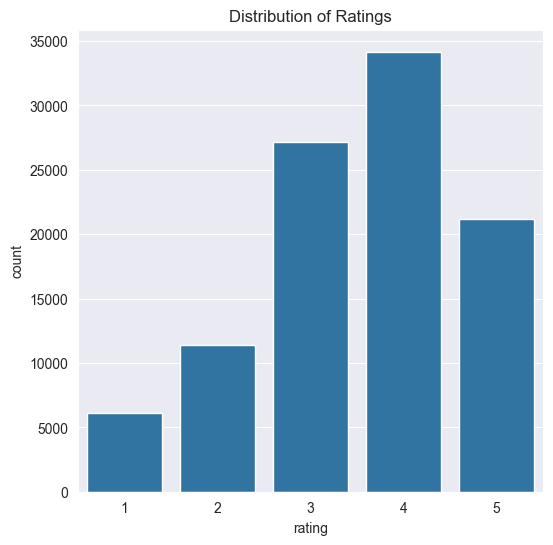

In [8]:
plot_distribution('Distribution of Ratings', ratings, plot_function=sns.countplot, x='rating')

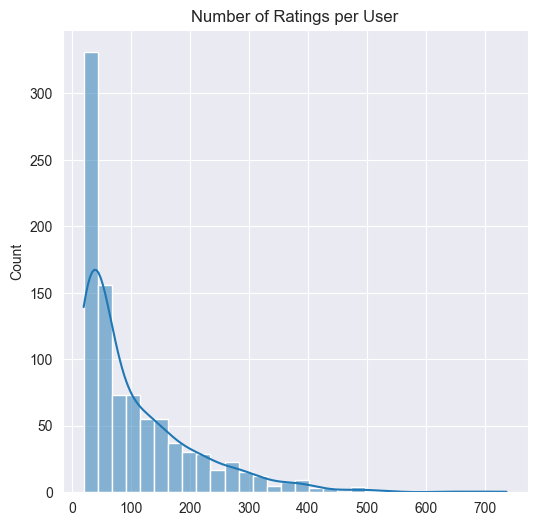

In [9]:
plot_distribution('Number of Ratings per User', ratings.groupby('user_id').size())

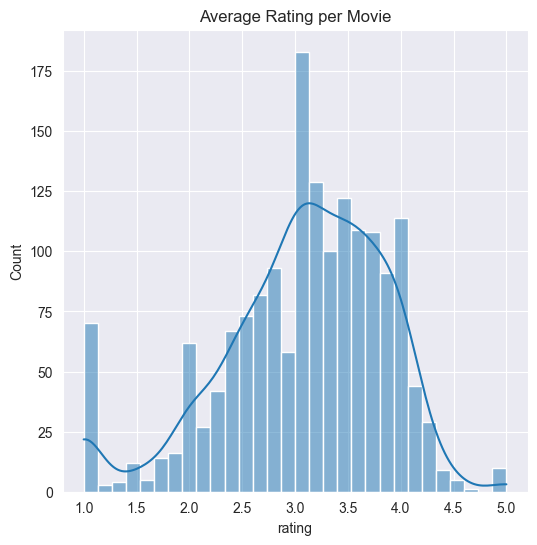

In [10]:
plot_distribution('Average Rating per Movie', ratings.groupby('movie_id')['rating'].mean())

User Distribution Visualization

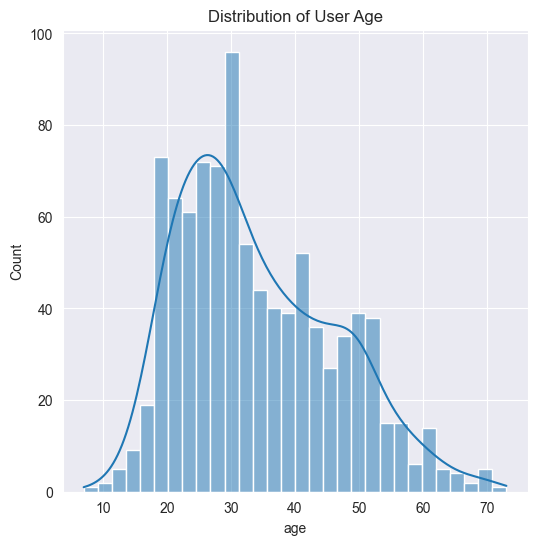

In [11]:
plot_distribution('Distribution of User Age', users['age'])

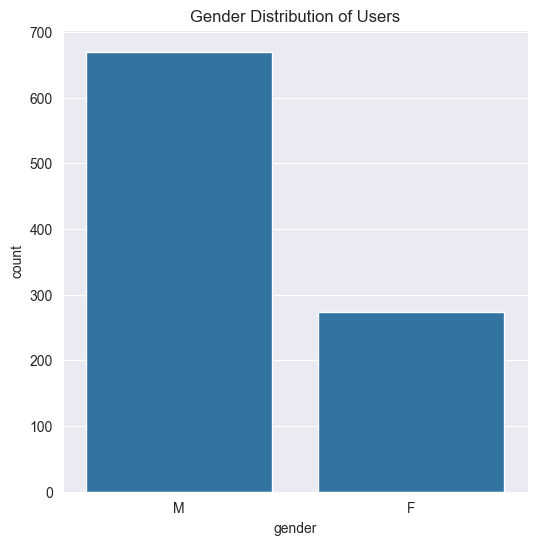

In [12]:
plot_distribution('Gender Distribution of Users', users, plot_function=sns.countplot, x='gender')

Movie Distribution Visualization

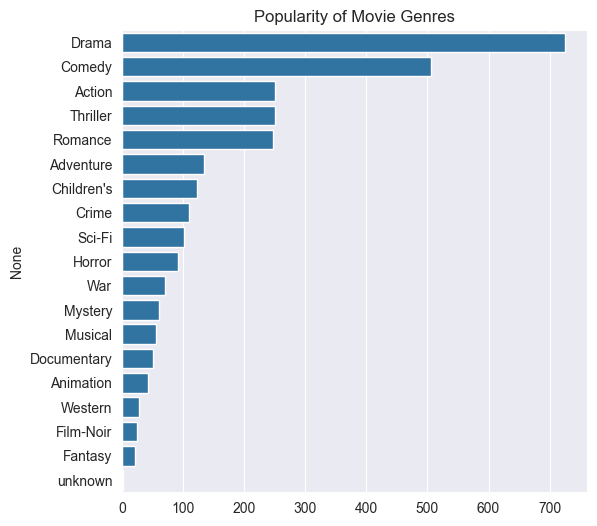

In [13]:
movie_genres = movies[['movie_id'] + GENRE_COLUMNS]
genres = movie_genres.columns.tolist()[1:]
genre_counts = movie_genres[genres].sum().sort_values(ascending=False)
plot_distribution('Popularity of Movie Genres',
                  movies,
                  plot_function=sns.barplot,
                  x=genre_counts.values,
                  y=genre_counts.index)

 ---
 
## Data Preprocessing

Drop Worthless Columns

In [14]:
movies = movies.drop(columns=['IMDb_URL', 'release_date'])
ratings = ratings.drop(columns=['timestamp'])

Handle Missing Values

In [15]:
movies.fillna(movies.mode().iloc[0], inplace=True)

Encoding Categorical Features

In [16]:
label_encoders = {}
for column in ['gender', 'occupation', 'zip_code']:
    label_encoders[column] = LabelEncoder()
    users[column] = label_encoders[column].fit_transform(users[column])

Create unique int id for each genre 

In [17]:
genre_columns = movies.columns[-len(GENRE_COLUMNS):]
genre_combination = movies[genre_columns].astype(str).agg('-'.join, axis=1)
genre_map = {genre: idx for idx, genre in enumerate(genre_combination.unique())}

movies['genre_id'] = genre_combination.map(genre_map)
movies = movies.drop(columns=genre_columns)

Feature Engineering

In [18]:
merged_data = merge(ratings, users, on='user_id').merge(movies, on='movie_id')

user_ratings = merged_data.groupby('user_id')['rating'].agg(
    ['mean', 'count']).rename(columns={'mean': 'user_avg_rating', 'count': 'user_rating_count'})

movie_ratings = merged_data.groupby('movie_id')['rating'].agg(
    ['mean', 'count']).rename(columns={'mean': 'movie_avg_rating', 'count': 'movie_rating_count'})

merged_data = merged_data.join(user_ratings, on='user_id').join(movie_ratings, on='movie_id')

Normalization

In [19]:
columns2normalize = ['age', 'rating', 'user_avg_rating', 'user_rating_count', 'movie_avg_rating', 'movie_rating_count']
merged_data[columns2normalize] = MinMaxScaler().fit_transform(merged_data[columns2normalize])

 ---
 
## Save Preprocessed File

In [20]:
merged_data.to_csv(PREPROCESSED_FILE_PATH, index=False)
merged_data.head()

,user_id,movie_id,rating,age,gender,occupation,zip_code,title,genre_id
0,196,242,0.50,0.636364,1,20,415,Kolya (1996),10
1,305,242,1.00,0.242424,1,14,690,Kolya (1996),10
2,6,242,0.75,0.530303,1,6,758,Kolya (1996),10
3,234,242,0.75,0.803030,1,15,707,Kolya (1996),10
4,63,242,0.50,0.363636,1,11,542,Kolya (1996),10
